In [1]:
import numpy as np
import cv2
from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
import medpy
%matplotlib inline

import pandas as pd
import torch

## Exploring Data from  usliverseq/volunteer01
The other volunteers seem to have emtpy video files. Volunteer 01 however is provided in bmp files. These can be used. It contains about 14500 frames, which need to be cropped and could be used for flow stimation. However, it is not clear how well they are really suited for it

In [11]:
path = "/Data/usliverseq/volunteer02.avi"
cap = cv2.VideoCapture(path)
frames = np.zeros(200)
i = 0
while(cap.isOpened()):
    ret,frame = cap.read() 
    print(frame)
    frames[i] = frame
    i += 1
    if i == 200:
        break

In [13]:
frames[100]

0.0

In [4]:
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=1000)
HTML(ani.to_html5_video())

This dataset is from USTRackedDataset. It contains ultrasound data, which is saved as mha file. The images can be processed into numpy arrays and seem to be clear, as they recorded invitro with a machine.
They are worth exploring for training!

In [2]:
#from medpy.io import load
import SimpleITK as sitk
img = sitk.ReadImage('Data/UsTrackedDataset/DATA/babyPhantom/completeSequence/Scan02_vel_0_00125_F15N/BP_Scan02_vel_0_00125_F_15N.mha', sitk.sitkFloat32)
#mage_data, image_header = load('Data/UsTrackedDataset/DATA/babyPhantom/completeSequence/Scan02_vel_0_00125_F15N/BP_Scan02_vel_0_00125_F_15N.mha')

In [4]:
array = sitk.GetArrayFromImage(img)

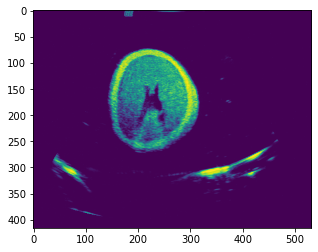

In [16]:
frames = []
fig, ax = plt.subplots()
for i in range(600):
    frames.append([ax.imshow(array[i])])

In [18]:
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=100)
HTML(ani.to_html5_video())

## Playing around with the abdominal phantom

In [1]:
from medpy.io import load

### Unprocessed Ultrasound data

In [4]:
mage_data, image_header = load('Data/abdominal_phantom/Scan01_A_0_05_P_0_0375/AP_Scan01_A_0_05_P_0_0375.mha')

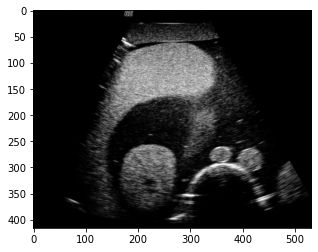

In [11]:
fig, ax = plt.subplots()
frames = []
for img in mage_data.T[9000:10000]:
    frames.append([ax.imshow(img, cmap='gray')])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=100)
HTML(ani.to_html5_video())

Could work. Needs to be explored in an experiment

| Frames | notes |
| --- | --- |
| 0-1000 | leave out |
| 1000-2000 | leave out |
| 2000-3000 | leave out |
| 3000-4000 | leave out |
| 4000-5000 | leave out |
| 5000-6000 | leave out |
| 6000-7000 | Can be used |
| 7000-8000 | leave out |
| 8000-9000 | leabe out |
| 9000-10000 | Can be used |


### Processed Us data

In [8]:
mage_data, image_header = load('Data/abdominal_phantom/Scan01_A_0_05_P_0_0375/AP_Reconstructed_Scan01_A_0_05_P_0_0375.mha')

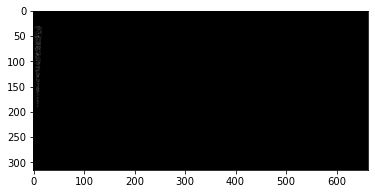

In [8]:
fig, ax = plt.subplots()
frames = []
for img in mage_data:
    frames.append([ax.imshow(img.T, cmap='gray')])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=100)
HTML(ani.to_html5_video())

Not sure if that is a good idea, or rather take the frames from the unprocessed

# Exploring COCOAI US Data images

In [68]:
import numpy as np
import cv2
from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
import os
import medpy
%matplotlib inline

import pandas as pd
import torch
import matplotlib.image as mpllimg
from utils.load_models import load_flownet2, load_pwcnet
from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.plotting import flow2img

import torch.nn.functional as F

In [69]:
path = "Data/cocoai-thinksono-data/compressions/"

In [70]:
print(len(os.listdir(path)))

3846


In [71]:
quality = pd.read_csv("Data/cocoai-thinksono-data/quality.csv")
quality

,ID,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,113.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,17
1,116.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,11
2,119.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12
3,120.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4,121.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
4762,11276.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,17
4763,11277.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,14
4764,11278.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4765,11280.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,12


There are some things, that need to be fulfilled in orer for the sequence to be used for training. The table below sums up all the different Columns and what needs to be fulfilled in order to use the ID for the training

| Quality Description | useable Index | Description |
|---|---|---|
|Vessel boundary| 1,2,4| Vessel partially cut of or fully visible during frames|
|LM configuration| 1,2,3,4| Landmarks don't need to be present for flow estimation|
|Vein contrast| 1,2 | some loss of contrast, but still visible|
|Artery contrast| 1,2 | some loss of contrast, but stil visible|
|shaprnes of Vein boundaries| 1,2,3 | up until poorly visible boundaries, We try to learn the overall flow|
|shaprnes of artery boundaries| 1,2,3 | up until poorly visible boundaries, We try to learn the overall flow|
|Overall gain| 1 | only good images are taken. Not too bright or too dark|
|artefacts| 1,2 | some aftefacts are present in the some frames|
| Movement Sequence| 1,2,3, | Exclude "lot's" of movement for now. The other indicate some slow or fast compression of the vein|


In [72]:
useable = quality[
    (quality["Vessel in Frame"] <3) &
    (quality['LM configuration'] < 5) &
    (quality['Vein contrast/cropping error'] < 3) &
    (quality['Artery contrast'] < 3) &
    (quality['Vein boundary'] < 4) &
    (quality['Artery boundary'] < 4) &
    (quality['Gain'] == 1) &
    (quality['Artefacts'] < 3) &
    (quality['Movement'] < 4)
]
useable

,ID,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,113.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,17
1,116.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,11
2,119.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12
3,120.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
5,124.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
4755,11246.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,15
4761,11274.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,13
4763,11277.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,14
4765,11280.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,12


Using the indices in the table mentioned above, 2048 examples can be used. From these 2048, I will first use max 500, to train and if everything works out, use the rest for validation. If I am ambitious, I can train on 2000 random examples and use 48 for validation. However, these have to be determined beforehand 

Below, the dataframe for the "compression" folder is shown. Here an overview over devices, anatomy, etc. is given

In [73]:
sequences = pd.read_csv("Data/cocoai-thinksono-data/sequences.csv")
sequences

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype
0,1,1,guys,RT,SFV1,LM5,healthy
1,2,1,guys,RT,SFV2,LM6,healthy
2,3,1,guys,LT,CFV / GSV + SFA / PFA,LM3,healthy
3,4,1,guys,LT,SFV1,LM5,healthy
4,5,1,guys,LT,SFV2,LM6,healthy
...,...,...,...,...,...,...,...
3862,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy
3863,5397,224,philips,RT,POPV,LM8,healthy
3864,5682,280,philips,RT,SFV + SFA,LM6,healthy
3865,5687,282,philips,RT,SFV + SFA,LM6,healthy


In [74]:
# load the first from useable
path_to_file = path + useable['ID'][0].astype(int).astype(str) + "/frames"
path_to_file

'Data/cocoai-thinksono-data/compressions/113/frames'

In [75]:
#fig, ax = plt.subplots()
#frames = []
#for file in os.listdir(path_to_file):
#    img = mpllimg.imread(os.path.join(path_to_file,file))
#    frames.append([ax.imshow(img)])
#ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
#                                repeat_delay=100)
#HTML(ani.to_html5_video())

In [76]:
flow2 = load_flownet2().cuda()

In [77]:
np.random.seed(10)
ridx = np.random.choice(os.listdir(path_to_file), 6)
ridx

array(['image_0043.png', 'image_0071.png', 'image_0039.png',
       'image_0094.png', 'image_0031.png', 'image_0068.png'], dtype='<U14')

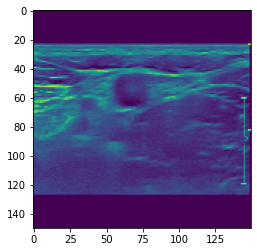

In [78]:
imgs = [torch.from_numpy(mpllimg.imread(os.path.join(path_to_file,file))).unsqueeze(2) for file in ridx]
plt.imshow(imgs[0])

In [148]:
#input_one = torch.cat((imgs[0].unsqueeze(0),imgs[0].unsqueeze(0),imgs[0].unsqueeze(0),imgs[1].unsqueeze(0),imgs[1].unsqueeze(0),imgs[1].unsqueeze(0)),0).unsqueeze(0).cuda()
#input_one.shape
#input_two = preprocessing_flownet(imgs[2].unsqueeze(0), imgs[3].unsqueeze(0)).cuda()
#input_three = preprocessing_flownet(imgs[4].unsqueeze(0), imgs[5].unsqueeze(0)).cuda()

# Somehow Flownet only accapts mutliple of 64 as input size (64, 128, 256, etc.) if the input is squared. Therefore i'll scale the image to 128 for training and eval
h = 150
size = (64,64)
W = 64
H = 64
img_fixed = F.interpolate(imgs[0].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1).numpy() 
img_moving = F.interpolate(imgs[1].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1).numpy()

print(img_fixed.shape)
img_fixed = np.concatenate([img_fixed, img_fixed, img_fixed], 2)
img_moving = np.concatenate([img_moving, img_moving, img_moving], 2)

images = [img_fixed, img_moving]
images = np.array(images).transpose(3, 0, 1, 2)
im = torch.from_numpy(images.astype(np.float32)).unsqueeze(0).cuda()
im.shape

(64, 64, 1)


torch.Size([1, 3, 2, 64, 64])

In [149]:
flow_one = flow2(im).squeeze().cpu()

torch.Size([1, 6, 64, 64])


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [151]:
data = flow_one.data.cpu().numpy().transpose(1,2,0)

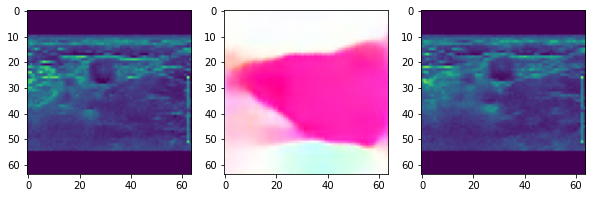

In [152]:
fig = plt.figure(figsize=(10,10))
plt.subplot(132)
plt.imshow(flow2img(data))
plt.subplot(131)
plt.imshow(F.interpolate(imgs[0].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1))
plt.subplot(133)
plt.imshow(F.interpolate(imgs[1].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1))

In [153]:
pwc = load_pwcnet().cuda()

/home/till/uni/MasterThesis/models/pwc_net/models/PWCNet.py:138: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


In [154]:
#images = im.reshape(1,6,size[0], size[1])
print(imgs[0].shape)
images = preprocessing_pwc(imgs[0], imgs[1])
images.shape

torch.Size([150, 150, 1])


torch.Size([1, 6, 192, 192])

In [155]:
pwc.eval()
flo = pwc(images.cuda())
print("Output: ", flo.shape)
flo = flo[0] * 20.0
flo = flo.cpu().data.numpy()
print("First entry to numpy: ", flo.shape)
# scale the flow back to the input size 
flo = np.swapaxes(np.swapaxes(flo, 0, 1), 1, 2) # 
u_ = cv2.resize(flo[:,:,0],(W,H))
v_ = cv2.resize(flo[:,:,1],(W,H))
u_ *= W/ float(64)
v_ *= H/ float(64)
flo = np.dstack((u_,v_))
print("Stacked: ", flo.shape)

torch.Size([1, 81, 3, 3])
Output:  torch.Size([1, 2, 48, 48])
First entry to numpy:  (2, 48, 48)
Stacked:  (64, 64, 2)


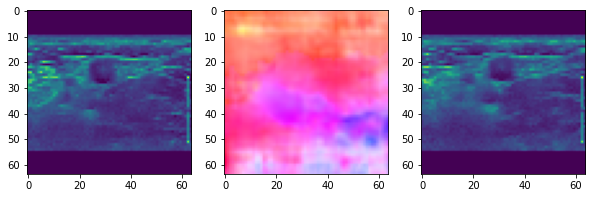

In [156]:
fig = plt.figure(figsize=(10,10))
plt.subplot(132)
plt.imshow(flow2img(flo))
plt.subplot(131)
plt.imshow(F.interpolate(imgs[0].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1))
plt.subplot(133)
plt.imshow(F.interpolate(imgs[1].reshape(1,1,150,150), size = size).reshape(size[0],size[1],1))